In [1]:
import sys
sys.path.insert(0,'..')

from src.models import *
from src.loss_functions import *
from src.noise import *
from src.metrics import *
from src.plotting import *
from src.generate_data import *
from src.real_data import *
from src.abstain import *

import sklearn
import pandas as pd

from scipy.stats import bernoulli

from operator import xor
from sklearn.preprocessing import StandardScaler

import pickle as pkl

In [2]:
def run_procedure(m, max_iter, X_train, yn_train, X_test, y_test, p_y_x_dict, group_train = None, group_test = None, noise_type = "class_independent", model_type = "LR", T = None, epsilon = 0.1, misspecify = False):
    
    typical_count = 0
    preds_train = []
    errors = []
    
    y_vec = yn_train
    
    for seed in tqdm(range(1, max_iter+1)):
        
        u_vec = infer_u(y_vec, group = group_train, noise_type = noise_type, p_y_x_dict = p_y_x_dict,  T = T , seed=seed)

        typical_flag, difference = is_typical(u_vec, p_y_x_dict, group = group_train,  T = T, y_vec = y_vec, noise_type = noise_type, uncertainty_type = "backward", epsilon = epsilon)

        if misspecify:
            typical_flag = True
            
        if not typical_flag:
            continue
            
        flipped_labels = flip_labels(y_vec, u_vec)
        
        model,  (train_acc,
                test_acc,
                train_probs,
                test_probs,
                train_loss,
                test_loss,
                train_preds,
                test_preds
                ) = train_model_ours(X_train, flipped_labels, X_test, y_test, seed = 2024, model_type=model_type)
        
        preds_train.append(train_preds)
        
        error = train_preds != flipped_labels
        errors.append(error)

        typical_count += 1

        if typical_count == m:
            break

    predictions_train = np.array(preds_train)
    
    #compute metrics
    disagreement_train = estimate_disagreement(predictions_train)
    ambiguity_train = calculate_error_rate(predictions_train, y_vec)
    new_ambiguity_train = np.mean(errors, axis=0)*100


    #print(predictions_train.shape, y_vec.shape)
    return ambiguity_train, new_ambiguity_train, train_probs


In [22]:
model_type = "LR"
noise_type = "class_conditional"

uncertainty_type = "forward"
metric = "regret_train"
fixed_class = 0
fixed_noise = 0
noise_level = 0.2



In [23]:
draws = 5
m= 500
max_iter = 10000

datasets = ["cshock_eicu"]

disagreement_trains = []
disagreement_tests = []
ambiguity_trains = []
ambiguity_tests = []
shifts = []
atypicalities = []

all_metrics = []

true_u_vecs = []

for dataset in datasets:
    
    X_train, X_test, y_train, y_test, group_train, group_test = load_dataset_splits(dataset, group = "age")

    p_y_x_dict =  calculate_prior(y_train, noise_type = noise_type, group=group_train) 


    for draw_id in range(draws):
        
        if noise_type == "class_independent":
            _, T_true = generate_class_independent_noise(y_train, noise_level)
        else:
            _, T_true = generate_class_conditional_noise(y_train, noise_level, fixed_class, fixed_noise)

        u_vec = get_u(y_train, T = T_true, seed= draw_id, noise_type = noise_type)
        true_u_vecs.append(u_vec)

        yn_train  = flip_labels(y_train, u_vec)

        T_est = T_true
        outs = run_procedure(m, max_iter, X_train, yn_train, X_test, y_test, p_y_x_dict, group_train = None, group_test = None, noise_type = noise_type, model_type = model_type, T = T_est, epsilon = 0.1, misspecify = True)

        for i, metric in enumerate(['ambiguity_train', 'new', "train_probs"]):

            all_metrics.append({
                                "dataset": dataset,
                                "model_type": model_type,
                                "noise_type": noise_type,
                                #"shift": shift,
                                #"err_method": method, #ignore err_method column for now
                                "metric": metric,
                                "value": outs[i],
                                'draw_id':draw_id
                        })




  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

In [24]:

df = pd.DataFrame(all_metrics)

df

,dataset,model_type,noise_type,metric,value,draw_id
0,cshock_eicu,LR,class_conditional,ambiguity_train,"[6.0, 77.4, 15.0, 0.0, 41.4, 0.0, 0.0, 21.6, 1...",0
1,cshock_eicu,LR,class_conditional,new,"[19.0, 77.4, 22.2, 0.0, 40.400000000000006, 0....",0
2,cshock_eicu,LR,class_conditional,train_probs,"[0.36631935360770435, 0.5044266540800383, 0.40...",0
3,cshock_eicu,LR,class_conditional,ambiguity_train,"[5.4, 97.0, 83.39999999999999, 0.0, 67.4, 0.0,...",1
4,cshock_eicu,LR,class_conditional,new,"[19.6, 97.0, 69.8, 0.0, 56.8, 0.0, 0.0, 40.2, ...",1
5,cshock_eicu,LR,class_conditional,train_probs,"[0.41252320426436134, 0.5086008036621401, 0.47...",1
6,cshock_eicu,LR,class_conditional,ambiguity_train,"[0.2, 92.4, 44.4, 0.0, 89.60000000000001, 0.0,...",2
7,cshock_eicu,LR,class_conditional,new,"[16.8, 92.4, 40.400000000000006, 0.0, 74.6, 0....",2
8,cshock_eicu,LR,class_conditional,train_probs,"[0.3071087186685543, 0.4869837444948937, 0.463...",2
9,cshock_eicu,LR,class_conditional,ambiguity_train,"[39.4, 99.0, 34.8, 0.0, 87.8, 100.0, 0.0, 54.2...",3


In [25]:
metrics = []
values = []
coverages = []
thresholds = []
losses = []
draw_ids = []
methods = []
datasets = []

for dataset in df["dataset"].unique():

    if noise_type == "class_independent":
        _, T_true = generate_class_independent_noise(y_train, noise_level)
    else:
        _, T_true = generate_class_conditional_noise(y_train, noise_level, fixed_class, fixed_noise)

    T_est = T_true
    for draw_id in df.draw_id.unique():

        sub_df = df[ (df["draw_id"] == draw_id)& (df["dataset"] == dataset)]

        metric_lis = ['clean_risk','regret', 'fpr', 'fnr']


        ambiguity = np.clip(sub_df[sub_df["metric"]=="ambiguity_train"].value.values[0] / 100, 0, 1)
        new = np.clip(sub_df[sub_df["metric"]=="new"].value.values[0] / 100, 0, 1)
        probs = sub_df[sub_df["metric"]=="train_probs"].value.values[0]

        X_train, X_test, y_train, y_test, group_train, group_test = load_dataset_splits(dataset, group = "age")

        p_y_x_dict =  calculate_prior(y_train, noise_type = noise_type, group=group_train) 


        u_vec = get_u(y_train, T=T_true, seed=draw_id, noise_type=noise_type) #True U
        y_vec = y_train
        yn_train = flip_labels(y_train, u_vec)  # XOR


        if probs.ndim == 2:
            preds = np.argmax(probs, axis=1)
            confidence = np.max(probs, axis=1)
        else:
            preds = (probs > 0.5).astype(int)
            confidence = np.where(probs > 0.5, probs, 1 - probs)

        uncertainty = 1 - confidence

        for method in ["ambiguity", "confidence"]:
            if method == "ambiguity":
                criteria = new ##UPDATED
            elif method == "confidence":
                criteria = uncertainty
            elif method == "new":
                criteria = new


            for abstain_percentage in np.linspace(0, 1.0, 25):

                abstain_metrics = compute_abstain_metrics(abstain_percentage, preds, criteria, y_vec = y_vec, train = True, yn_vec = yn_train)

                for metric in metric_lis:


                    metrics.append(metric)

                    values.append(abstain_metrics[metric])
                    coverages.append(abstain_metrics['coverage'])

                    thresholds.append(abstain_percentage)
                    

                    draw_ids.append(draw_id)
                    methods.append(method)
                    datasets.append(dataset)

# Create a DataFrame from the arrays
data = pd.DataFrame({
    'dataset': datasets,
    'metric': metrics,
    'value': values,
    'coverage': coverages,
    'threshold': thresholds,
    'draw_id': draw_ids,
    'method': methods
})


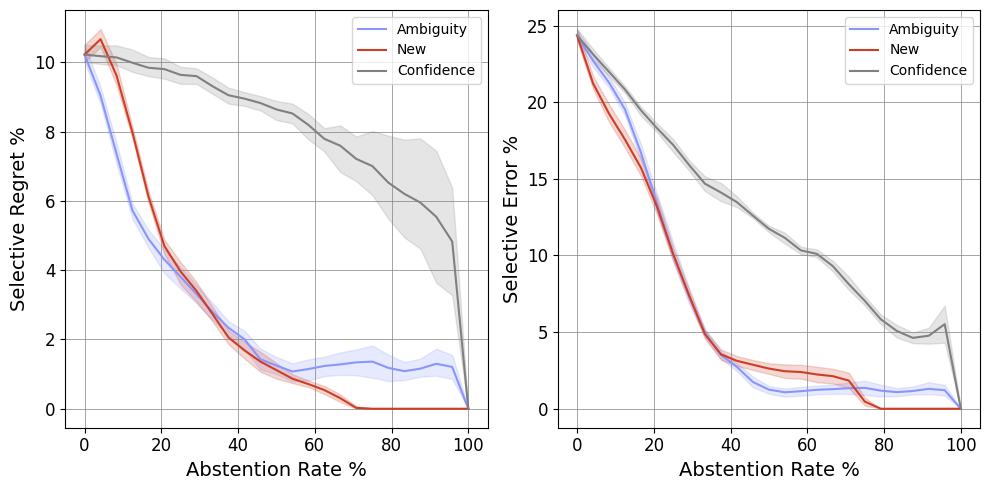

In [26]:

dataset_titles = {
    "cshock_eicu": "shock_eicu",
    "cshock_mimic": "shock_mimic",
    "saps": "mortality",
    "support": "support",
    "lungcancer": "lungcancer"
}



# Define your custom color palette for each method
method_colors = {
    "Ambiguity": "#8896FB",  # Purple
    "Confidence": "#ce3d26",  # Gray
    "Random": "#ce3d26",# Red
    "New":"#ce3d26"
}

y_labels = {"regret": "Selective Regret %",
           "clean_risk": "Selective Error %"}

# Create a figure with 2 rows (one for each metric) and 6 columns (one for each dataset)
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharex=True)

# Loop through each dataset and plot the metrics
for idx, metric in enumerate(["regret", "clean_risk"]):

        
    # Capitalize first letter of the method names to match color mapping
    data['method'] = data['method'].str.capitalize()

    data["abstention"] = 100 - data["coverage"]

    # Subset data based on loss_type and noise_level if needed

    sub_data = data

    # Plot each metric in its respective position in the grid

    ax = axes[idx]

    # For each method, plot the line for the selected metric
    for method in sub_data['method'].unique():
        method_data = sub_data[(sub_data['method'] == method) & (sub_data['metric'] == metric)]
        sns.lineplot(data=method_data, x="abstention", y="value", ax=ax, color=method_colors.get(method, "#808080"), label=method)

    # Set labels and grid
    ax.set_xlabel("Abstention Rate %", fontsize=14)

    ax.set_ylabel(y_labels[metric], fontsize=14)

    ax.grid(True, which='both', color='grey', linestyle='-', linewidth=0.5)
    ax.tick_params(axis='both', which='major', labelsize=12)


# Adjust the layout to give space for the bottom legend
plt.tight_layout()

#plt.savefig('/h/snagaraj/noise_multiplicity/figures/abstain.pdf', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

In [27]:
data

,dataset,metric,value,coverage,threshold,draw_id,method,abstention
0,cshock_eicu,clean_risk,25.144718,100.000000,0.000000,0,Ambiguity,0.000000
1,cshock_eicu,regret,10.130246,100.000000,0.000000,0,Ambiguity,0.000000
2,cshock_eicu,fpr,7.489146,100.000000,0.000000,0,Ambiguity,0.000000
3,cshock_eicu,fnr,2.641100,100.000000,0.000000,0,Ambiguity,0.000000
4,cshock_eicu,clean_risk,23.518309,95.839363,0.041667,0,Ambiguity,4.160637
...,...,...,...,...,...,...,...,...
1495,cshock_eicu,fnr,0.862069,4.196816,0.958333,4,Confidence,95.803184
1496,cshock_eicu,clean_risk,0.000000,0.000000,1.000000,4,Confidence,100.000000
1497,cshock_eicu,regret,0.000000,0.000000,1.000000,4,Confidence,100.000000
1498,cshock_eicu,fpr,0.000000,0.000000,1.000000,4,Confidence,100.000000
